In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [25]:
# Transformasi data
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [26]:
# Dataset MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [27]:
# Tentukan device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# CNN Model
class CNN(nn.Module):
    def __init__(self, kernel_size=3, pooling_type='max'):
        super(CNN, self).__init__()
        self.pooling_type = pooling_type

        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 7x7 adalah hasil pooling dua kali pada input 28x28
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        if self.pooling_type == 'max':
            x = F.max_pool2d(x, 2)
        elif self.pooling_type == 'avg':
            x = F.avg_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        if self.pooling_type == 'max':
            x = F.max_pool2d(x, 2)
        elif self.pooling_type == 'avg':
            x = F.avg_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [29]:
# Fungsi untuk melatih model dengan early stopping
def train_model_with_early_stop(model, optimizer, scheduler, num_epochs=10, patience=5):
    criterion = nn.CrossEntropyLoss()
    train_losses, test_losses, test_accuracies = [], [], []

    best_accuracy = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluasi
        model.eval()
        test_loss, correct = 0.0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        accuracy = correct / len(test_loader.dataset)
        test_accuracies.append(accuracy)

        scheduler.step(test_loss)

        # Early stopping logic
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0  # Reset counter if accuracy improves
        else:
            patience_counter += 1

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.4f}")

        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

    return train_losses, test_losses, test_accuracies

In [30]:
# Parameters to Compare
kernel_sizes = [3, 5]
pooling_types = ['max', 'avg']
optimizers_to_compare = {
    'SGD': lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    'RMSProp': lambda params: optim.RMSprop(params, lr=0.01),
    'Adam': lambda params: optim.Adam(params, lr=0.001)
}
epochs_list = [5, 100]

In [31]:
# Simpan hasil
results = {}

for kernel_size in kernel_sizes:
    for pooling_type in pooling_types:
        for opt_name, opt_fn in optimizers_to_compare.items():
            for num_epochs in epochs_list:
                print(f"Running for Kernel: {kernel_size}, Pooling: {pooling_type}, Optimizer: {opt_name}, Epochs: {num_epochs}")

                model = CNN(kernel_size=kernel_size, pooling_type=pooling_type).to(device)
                optimizer = opt_fn(model.parameters())
                scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

                train_losses, test_losses, test_accuracies = train_model_with_early_stop(
                    model, optimizer, scheduler, num_epochs=num_epochs, patience=5
                )

                key = f"Kernel-{kernel_size}_Pooling-{pooling_type}_Opt-{opt_name}_Epochs-{num_epochs}"
                results[key] = {
                    'train_losses': train_losses,
                    'test_losses': test_losses,
                    'test_accuracies': test_accuracies
                }


Running for Kernel: 3, Pooling: max, Optimizer: SGD, Epochs: 5
Epoch 1/5, Loss: 0.1895, Test Loss: 0.0000, Accuracy: 0.9855
Epoch 2/5, Loss: 0.0489, Test Loss: 0.0000, Accuracy: 0.9874
Epoch 3/5, Loss: 0.0324, Test Loss: 0.0000, Accuracy: 0.9905
Epoch 4/5, Loss: 0.0247, Test Loss: 0.0000, Accuracy: 0.9897
Epoch 5/5, Loss: 0.0181, Test Loss: 0.0000, Accuracy: 0.9909
Running for Kernel: 3, Pooling: max, Optimizer: SGD, Epochs: 100
Epoch 1/100, Loss: 0.1888, Test Loss: 0.0001, Accuracy: 0.9723
Epoch 2/100, Loss: 0.0488, Test Loss: 0.0000, Accuracy: 0.9892
Epoch 3/100, Loss: 0.0350, Test Loss: 0.0000, Accuracy: 0.9888
Epoch 4/100, Loss: 0.0259, Test Loss: 0.0000, Accuracy: 0.9885
Epoch 5/100, Loss: 0.0201, Test Loss: 0.0000, Accuracy: 0.9910
Epoch 6/100, Loss: 0.0158, Test Loss: 0.0000, Accuracy: 0.9898
Epoch 7/100, Loss: 0.0120, Test Loss: 0.0000, Accuracy: 0.9917
Epoch 8/100, Loss: 0.0100, Test Loss: 0.0000, Accuracy: 0.9914
Epoch 9/100, Loss: 0.0074, Test Loss: 0.0000, Accuracy: 0.9907


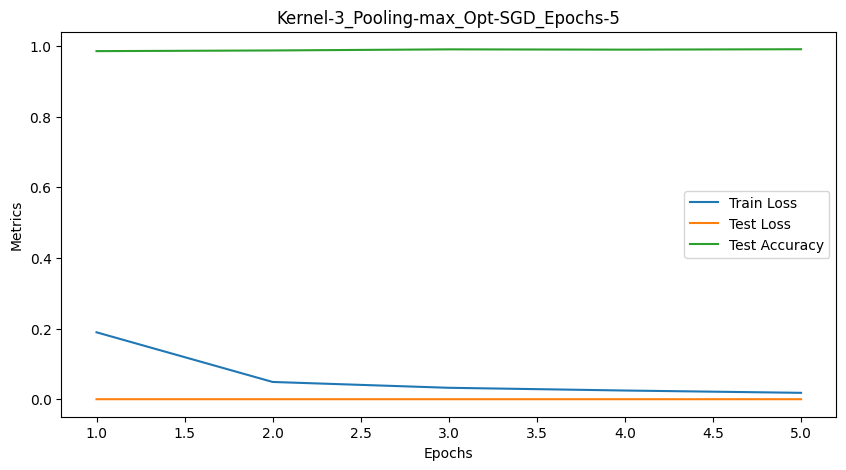

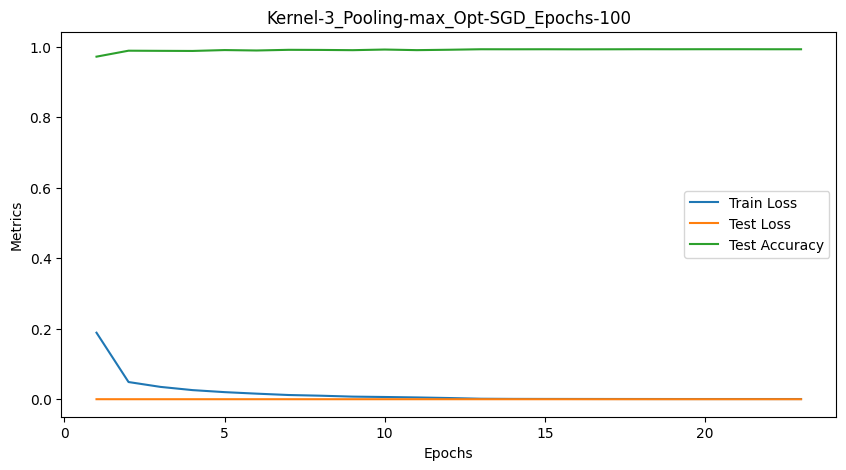

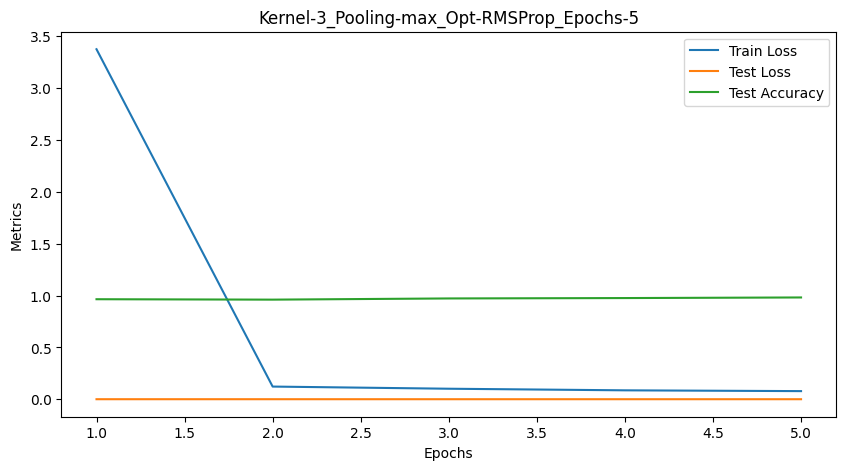

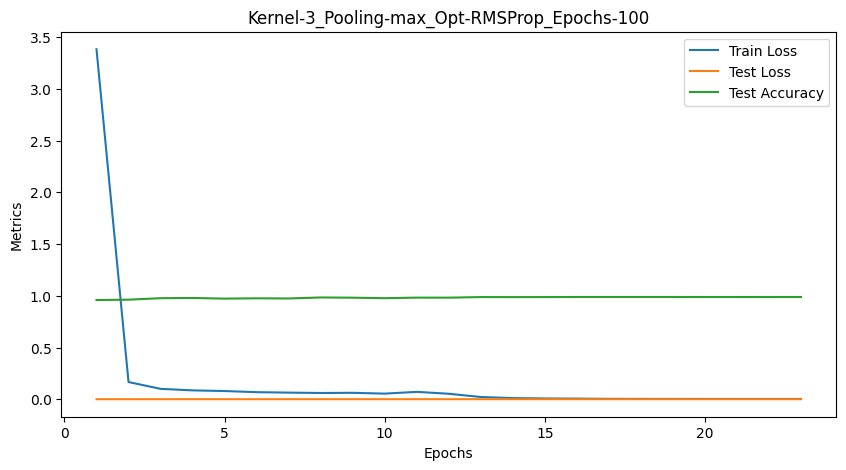

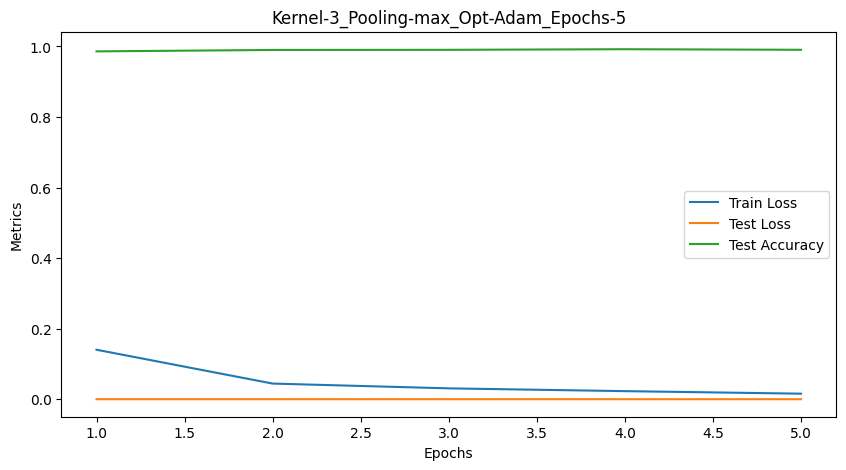

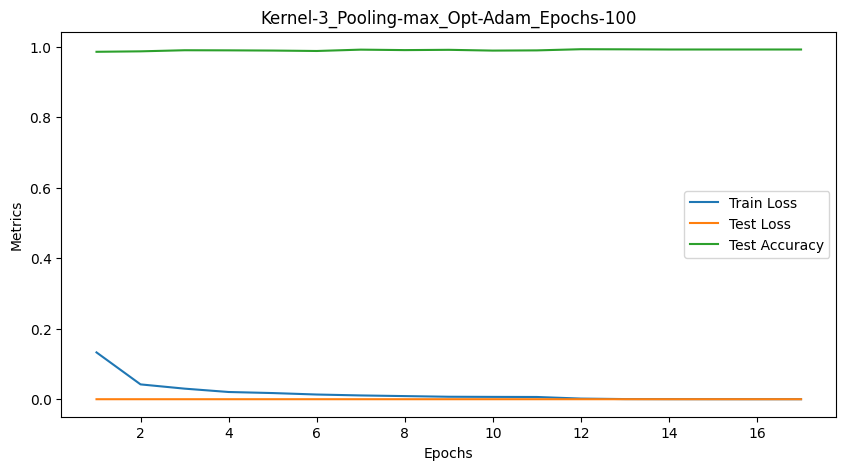

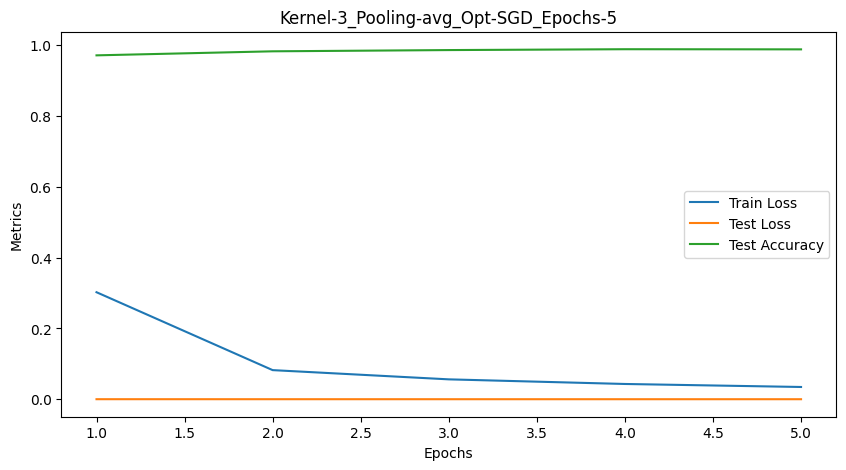

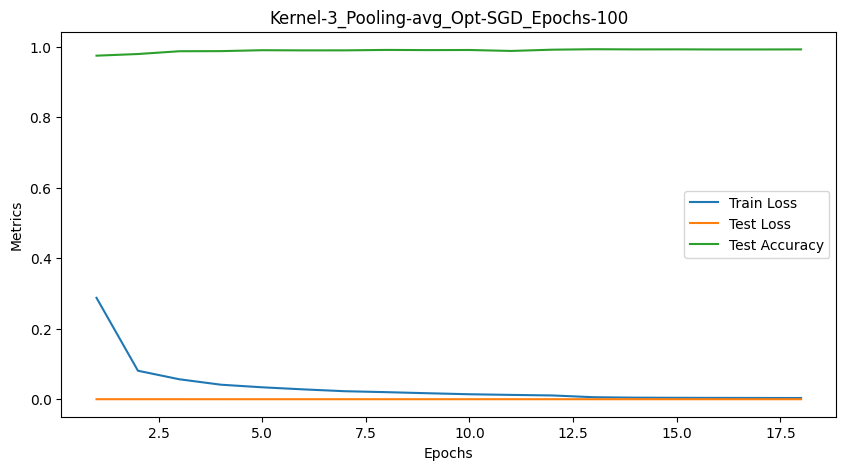

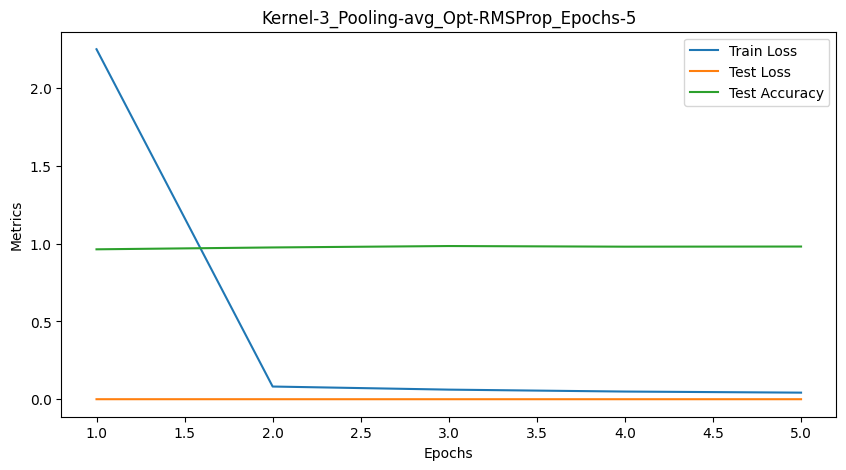

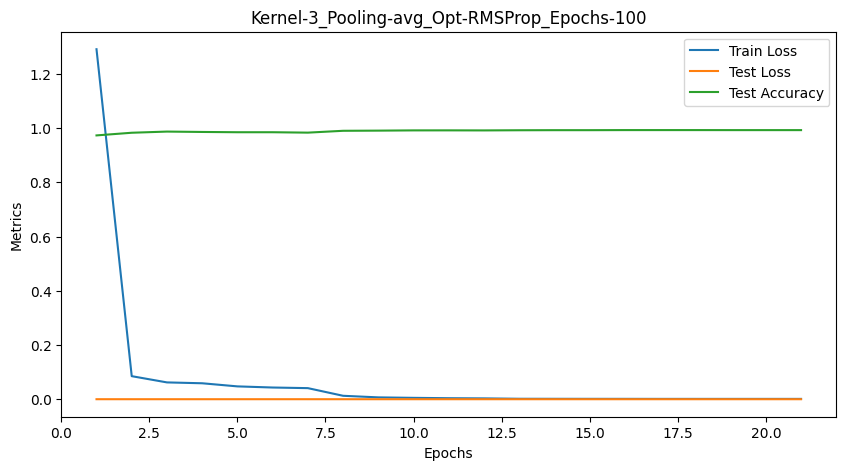

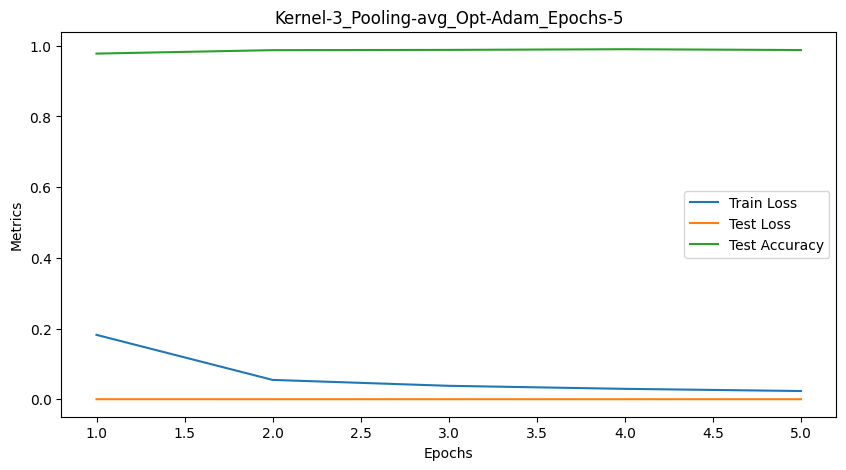

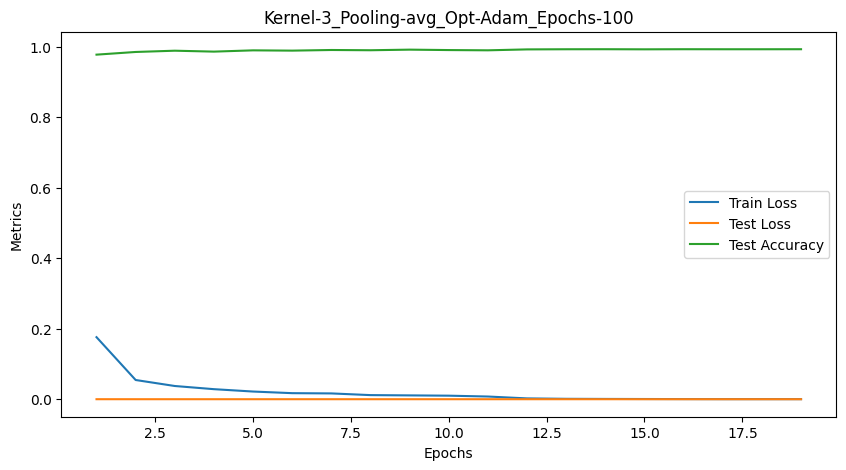

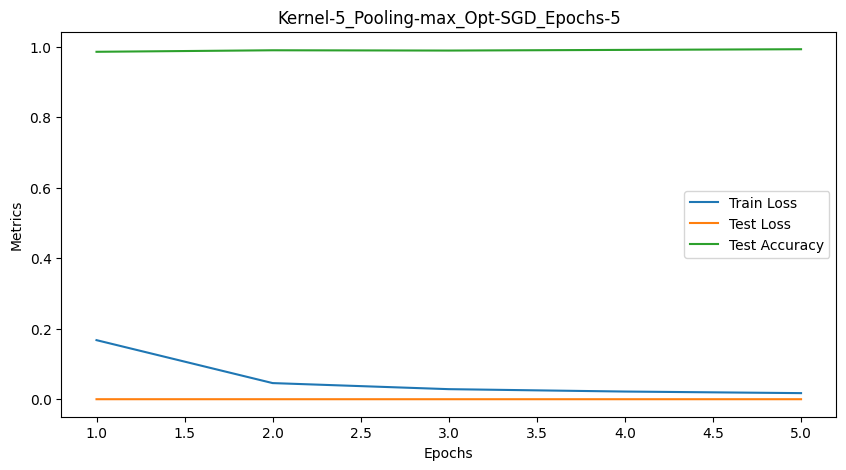

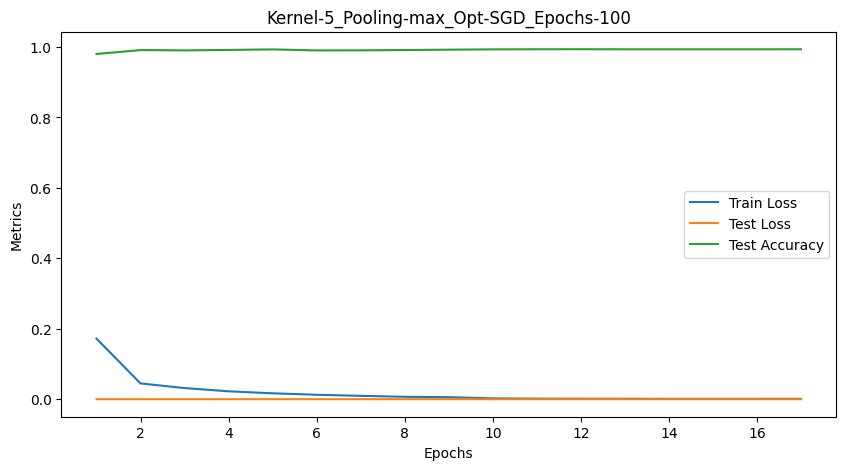

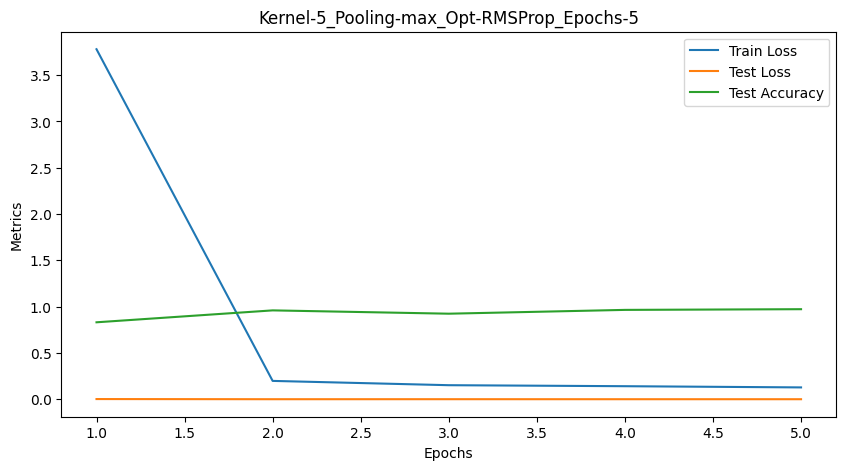

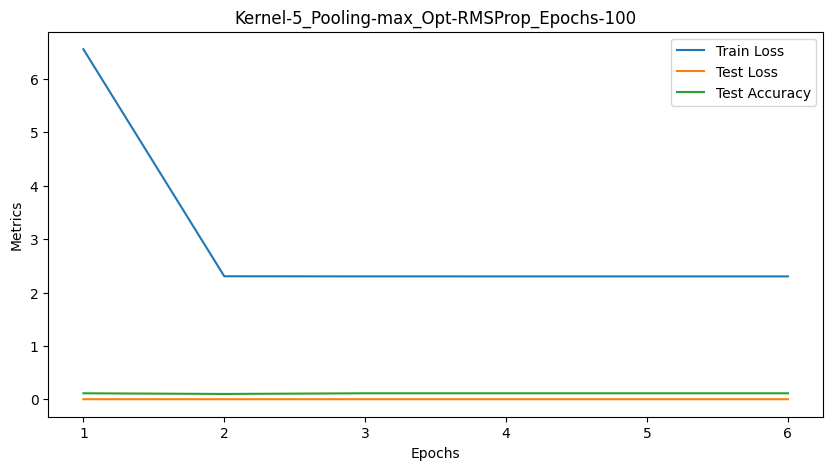

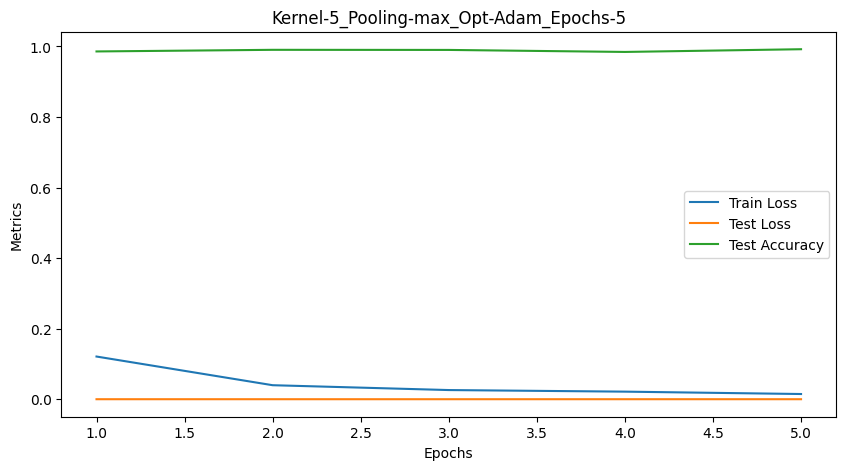

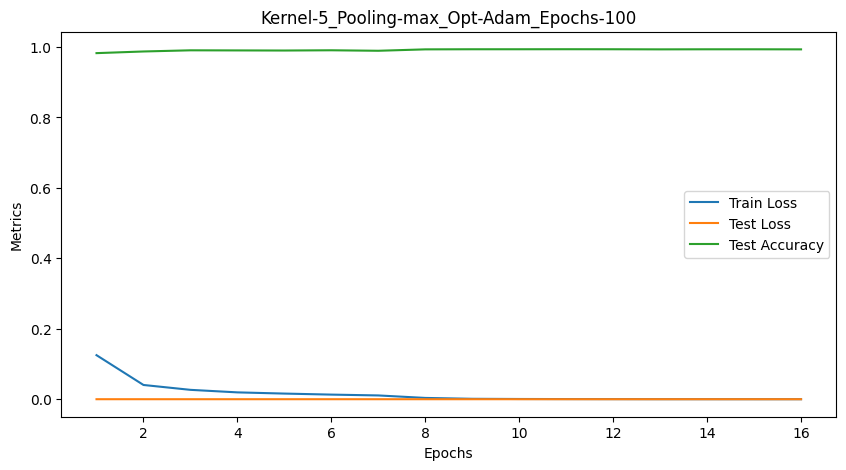

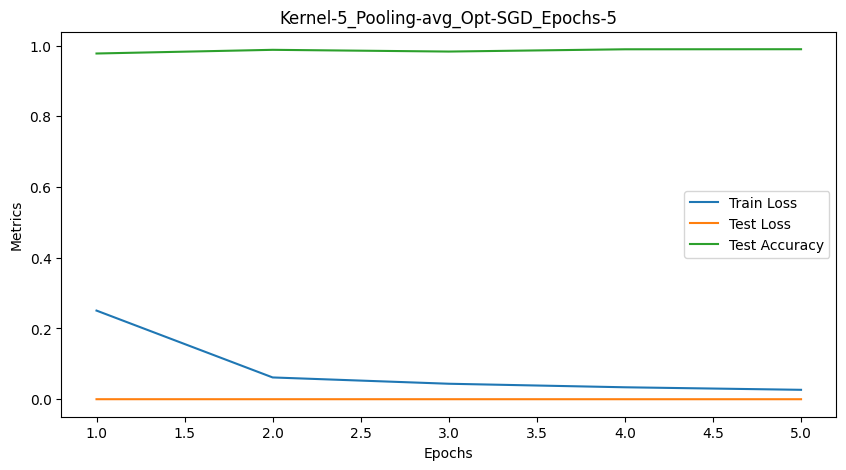

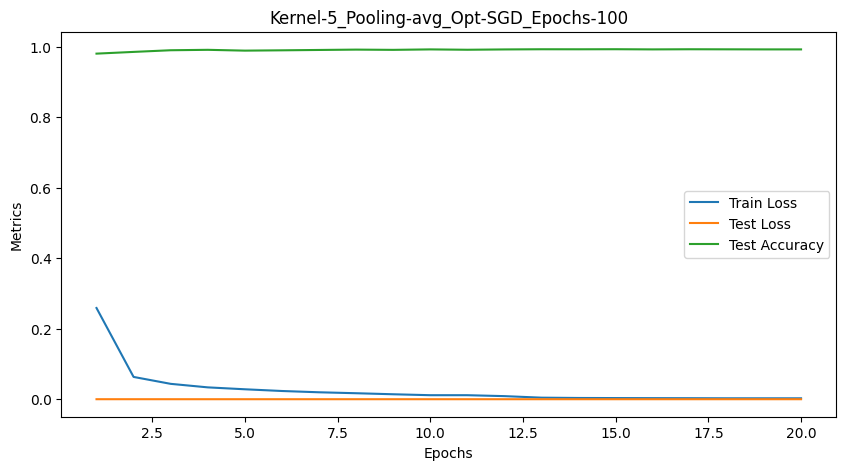

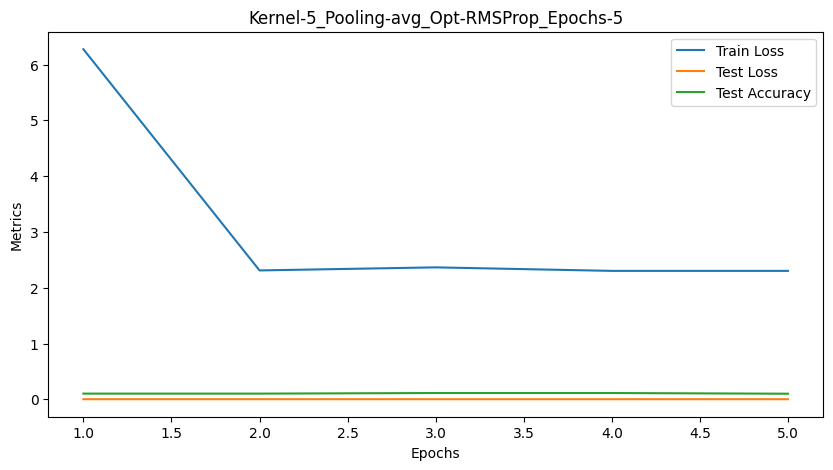

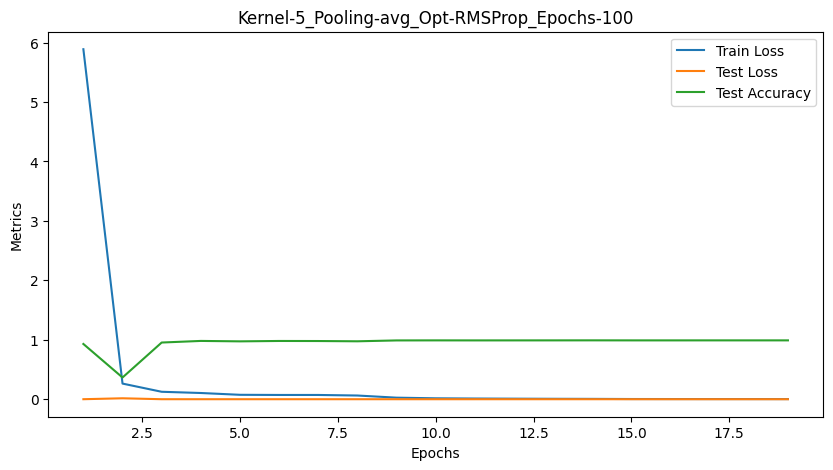

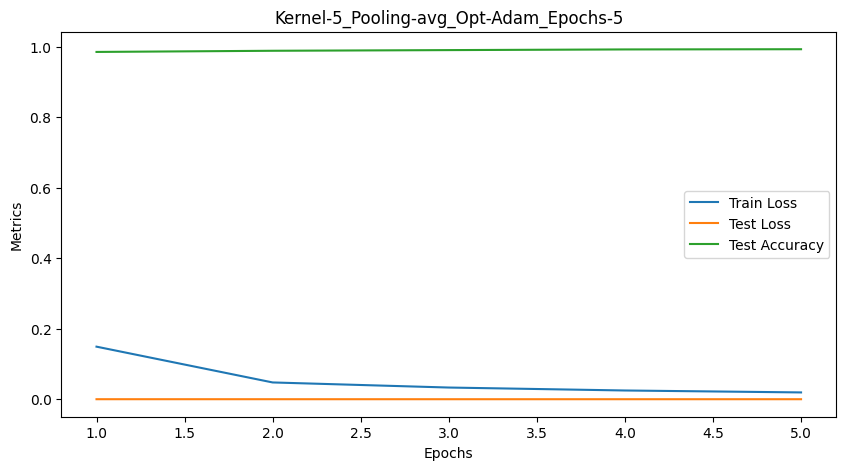

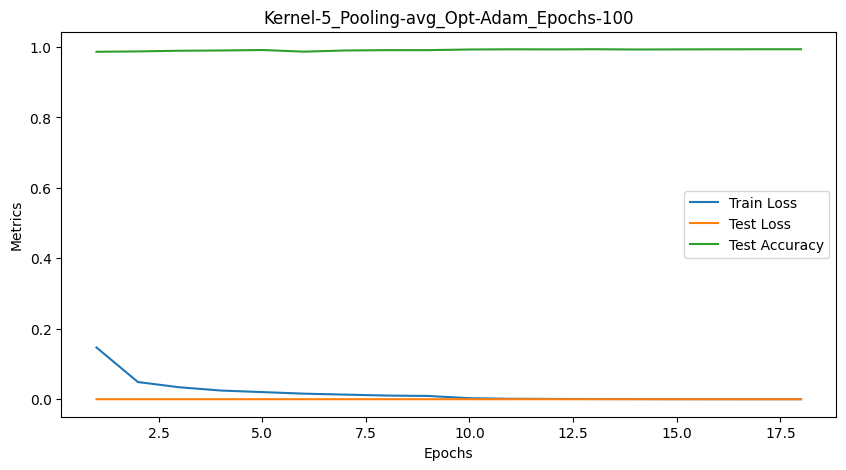

In [32]:
# Visualisasi hasil
for key, result in results.items():
    epochs = range(1, len(result['train_losses']) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, result['train_losses'], label='Train Loss')
    plt.plot(epochs, result['test_losses'], label='Test Loss')
    plt.plot(epochs, result['test_accuracies'], label='Test Accuracy')
    plt.title(key)
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()